In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [2]:
import torch

In [3]:
# Load the dataset (Unstructured clinical notes)
noteevents = pd.read_csv('NOTEEVENTS.csv.gz')

# Preview the dataset
noteevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [4]:
# Check data types and non-null counts
noteevents.info()

# Identify missing values
missing = noteevents.isnull().sum()
print(missing[missing > 0])

# Drop duplicate rows if any
duplicates = noteevents.duplicated().sum()
print(f'Total duplicate rows: {duplicates}')
noteevents.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB
HADM_ID       231836
CHARTTIME     316566
STORETIME     836776
CGID          836776
ISERROR      2082294
dtype: int64
Total duplicate rows: 0


In [5]:
# Convert CHARTDATE, CHARTTIME, and STORETIME to datetime objects
noteevents['CHARTDATE'] = pd.to_datetime(noteevents['CHARTDATE'], errors='coerce')
noteevents['CHARTTIME'] = pd.to_datetime(noteevents['CHARTTIME'], errors='coerce')
noteevents['STORETIME'] = pd.to_datetime(noteevents['STORETIME'], errors='coerce')
noteevents.dtypes


ROW_ID                  int64
SUBJECT_ID              int64
HADM_ID               float64
CHARTDATE      datetime64[ns]
CHARTTIME      datetime64[ns]
STORETIME      datetime64[ns]
CATEGORY               object
DESCRIPTION            object
CGID                  float64
ISERROR               float64
TEXT                   object
dtype: object

In [6]:
# Encode selected categorical columns
categorical_cols = ['CATEGORY', 'DESCRIPTION']
for col in categorical_cols:
    noteevents[col + '_ENC'] = noteevents[col].astype('category').cat.codes

# Display unique values for verification
noteevents[[col for col in categorical_cols]].drop_duplicates().head()


,CATEGORY,DESCRIPTION
0,Discharge summary,Report
50908,Discharge summary,Addendum
52108,Echo,Report
52120,ECG,Report
308691,Nursing,Nursing Transfer Note


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Normalize ROW_ID
scaler = MinMaxScaler()
noteevents['ROW_ID_scaled'] = scaler.fit_transform(noteevents[['ROW_ID']])
noteevents[['ROW_ID', 'ROW_ID_scaled']].head()


,ROW_ID,ROW_ID_scaled
0,174,0.000083
1,175,0.000084
2,176,0.000084
3,177,0.000084
4,178,0.000085


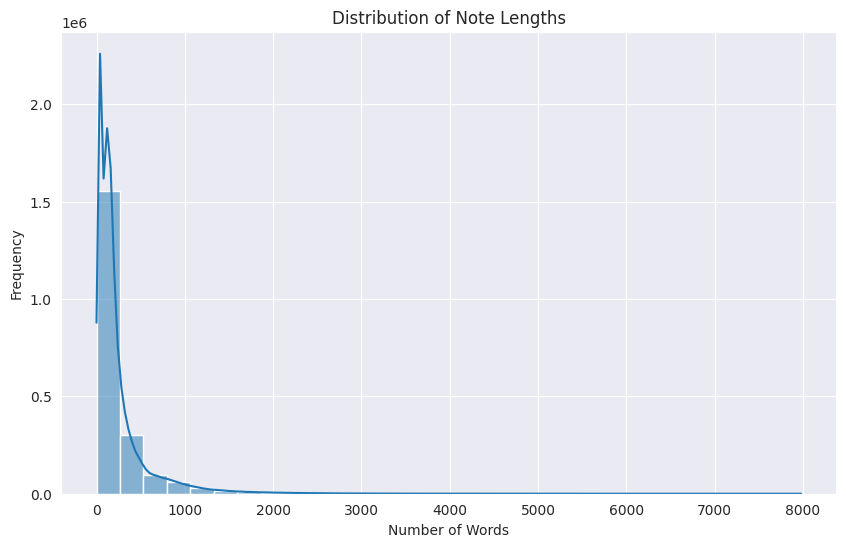

In [8]:
# Calculate note lengths
noteevents['TEXT_LENGTH'] = noteevents['TEXT'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(noteevents['TEXT_LENGTH'], kde=True, bins=30)
plt.title('Distribution of Note Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [9]:
noteevents.to_csv('noteevents_cleaned.csv', index=False)


In [10]:
!pip install sdv



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import os
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Set environment variables for multiprocessing
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

# Load the cleaned dataset
noteevents_cleaned = pd.read_csv('noteevents_cleaned.csv')


In [12]:
# Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(noteevents_cleaned)

# Initialize and fit the synthesizer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=300)
synthesizer.fit(noteevents_cleaned)


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
CHARTDATE              11
CHARTTIME              11
STORETIME              11
CATEGORY               15
DESCRIPTION            3848
CGID                   11
ISERROR                2
TEXT                   2023185
CATEGORY_ENC           11
DESCRIPTION_ENC        11
TEXT_LENGTH            11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)


MemoryError: Unable to allocate 906. GiB for an array with shape (2083180, 58361) and data type int64

In [13]:
# Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_noteevents.csv", index=False)
synthetic_data.head()


SamplingError: This synthesizer has not been fitted. Please fit your synthesizer first before sampling synthetic data.

In [ ]:
# Compare distributions of a categorical column
column = 'CATEGORY_ENC'

plt.figure(figsize=(10,5))
sns.histplot(noteevents_cleaned[column], color='blue', label='Real', alpha=0.5, kde=True)
sns.histplot(synthetic_data[column], color='red', label='Synthetic', alpha=0.5, kde=True)

plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.show()


In [ ]:
# Create a binary target based on TEXT_LENGTH
noteevents_cleaned['TARGET'] = (noteevents_cleaned['TEXT_LENGTH'] > 100).astype(int)
synthetic_data['TARGET'] = (synthetic_data['TEXT_LENGTH'] > 100).astype(int)

features = ['CATEGORY_ENC', 'DESCRIPTION_ENC']
target = 'TARGET'

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Real data model
X_real = noteevents_cleaned[features]
y_real = noteevents_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"Model accuracy on real data:     {real_acc:.2f}")
print(f"Model accuracy on synthetic data:{syn_acc:.2f}")


In [ ]:
 from sdv.single_table import TVAESynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and target (from D_CPT structure)
features = ['CATEGORY_ENC', 'DESCRIPTION_ENC']
target_col = 'TARGET'

# Create binary classification target
noteevents_cleaned['target'] = (noteevents_cleaned[target_col] > noteevents_cleaned[target_col].median()).astype(int)

# Regenerate metadata (if needed)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(noteevents_cleaned.drop(columns=['target']))

# Fit TVAE (drop target column before fitting)
vae_synthesizer = TVAESynthesizer(metadata=metadata, epochs=30)
vae_synthesizer.fit(noteevents_cleaned.drop(columns=['target']))

# Sample synthetic data
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

# Add target to synthetic data
synthetic_data_vae['target'] = (synthetic_data_vae[target_col] > noteevents_cleaned[target_col].median()).astype(int)

# Encode categorical features
for col in features:
    noteevents_cleaned[col] = noteevents_cleaned[col].astype('category').cat.codes
    synthetic_data_vae[col] = synthetic_data_vae[col].astype('category').cat.codes

# Train/test split
X_real = noteevents_cleaned[features]
y_real = noteevents_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

# Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Results
print(f"Model accuracy on REAL D_CPT data: {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC D_CPT: {vae_acc:.2f}")

In [ ]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()